In [1]:
import os
import re

import matplotx
import pandas as pd

from processor.filters import cut_by_window
from utils import load_df_with_time_index
import matplotlib.pyplot as plt
from typing import Callable
import pickle as pkl
import seaborn as sns

In [2]:
def duration_extractor(meta):
    match = re.search(r'{__name__="([^"]+)", group="::(([a-zA-Z0-9]+)_?([a-zA-Z0-9]+)?)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(3), match.group(4), match.group(5)
    return None, None, None, None

def requests_extractor(meta):
    match = re.search(r'::([a-zA-Z0-9]+)_?(.*)?', meta)
    if match:
        group = match.group(1)
        method = match.group(2) if match.group(2) else None
        return group, method
    return None, None


def get_os_and_processor(name: str) -> tuple[str, str]:
    os_ = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os_, processor

In [3]:
def merge_grouped_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame], field_extractor: tuple[list,Callable]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df = df.melt(var_name='meta', value_name='value', ignore_index=False)
        df[field_extractor[0]] = df['meta'].apply(lambda x: pd.Series(field_extractor[1](x)))
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        # Apply extract_fields to the 'meta' column
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

In [4]:
def save_plot_if_new(filename: str, dpi: int = 300, style: str = matplotx.styles.dracula, force: bool = False):
    """
    Save the current matplotlib figure to `filename` only if it does not exist.
    """
    if force and os.path.exists(filename):
        os.remove(filename)

    if not os.path.exists(filename):
        if style:
            with plt.style.context(style):
                plt.savefig(filename, dpi=dpi, transparent=True)
        else:
            plt.savefig(filename, dpi=dpi, transparent=True)
        print(f"Plot saved to {filename}")

In [5]:
def select_scenario_values(df: pd.DataFrame, scenario: str, methods:list[str], columns:list[str], timeframe:tuple[str,str] ) -> pd.DataFrame:
    filtered = df[df['scenario'] == scenario]
    filtered = filtered[filtered['method'].isin(methods)]
    filtered = filtered[columns]
    filtered = cut_by_window(filtered, *timeframe)
    return filtered

In [6]:
def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance",
                   ax: plt.Axes | None = None, palette:dict=None):
    if palette is None:
        instances = df[grouper].unique()
        palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        color = palette.get(name)
        group.plot(use_index=True, y=y_col, label=name, ax=ax, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()

In [7]:
def plot_grouped_means_with_palette(
        df: pd.DataFrame,
        value_col: str,
        ax: plt.Axes,
        group_col: str = "instance",
        palette = None,
        line_style: str = "--",
        label_fmt: str = r"$\bar{{x}}$={mean:.2f}s $\sigma$={std:.2f}s"
):
    if palette is None:
        palette_name = "tab10"
        instances = df[group_col].unique()
        palette = dict(zip(instances, sns.color_palette(palette_name, len(instances))))
    for name, group in df.groupby(group_col):
        mean_value = group[value_col].mean()
        std_value = group[value_col].std()
        ax.axhline(
            mean_value,
            color=palette[name],
            linestyle=line_style,
            label=label_fmt.format(mean=mean_value, std=std_value)
        )

In [8]:
def plot_grouped_queries_over_time(df: pd.DataFrame, groups: list[str],title: str, subtitle, y_label:str, axes:list =None, grouper: str = "group", plot_col: str = "value", plot_means:bool =False):
    instances = df["instance"].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    if axes is None:
        fig, axes = plt.subplots(len(groups), 1, figsize=(6, 6), sharex=True)
    for i, group in enumerate(groups):

        ax = axes[i]
        to_plot = df[df[grouper] == group]
        plot_over_time(to_plot, plot_col, f'{group} {subtitle}', y_label, ax=ax, palette=palette)
        ax.set_title(f'{group}')
        ax.set_ylabel(y_label)
        if i < len(axes) - 1:
            ax.tick_params(labelbottom=False)
            ax.set_xlabel('')
        if plot_means:
            plot_grouped_means_with_palette(to_plot, plot_col, ax, palette=palette, group_col="instance")
            ax.legend()
    plt.suptitle(title)
    plt.tight_layout()

In [9]:
data_ = pkl.load(open("results/quick_data.pkl", "rb"))

In [10]:
working_columns = ["value", "scenario", "instance", "method"]
working_methods = ['GetNewOrderHed', 'MasterUpdate', 'GetByID']
time_frame = ("20m", "40m")

group_duration = merge_grouped_dashboards(data_, "Group Duration", load_df_with_time_index, (['count_name', 'group','method', 'scenario'],duration_extractor))
sales_order_entry_durations = select_scenario_values(group_duration, "SalesOrderEntry", working_methods, working_columns, time_frame)

In [11]:
group_requests = merge_grouped_dashboards(data_, "Group Requests", load_df_with_time_index,(["scenario", "method"], requests_extractor))
sales_order_entry_requests = select_scenario_values(group_requests, "SalesOrderEntry", working_methods, working_columns, time_frame)

In [12]:
group_ttfb = merge_grouped_dashboards(data_, "Group TTFB", load_df_with_time_index,(["scenario", "method"], requests_extractor))
sales_order_entry_ttfb = select_scenario_values(group_ttfb, "SalesOrderEntry", working_methods, working_columns, time_frame)

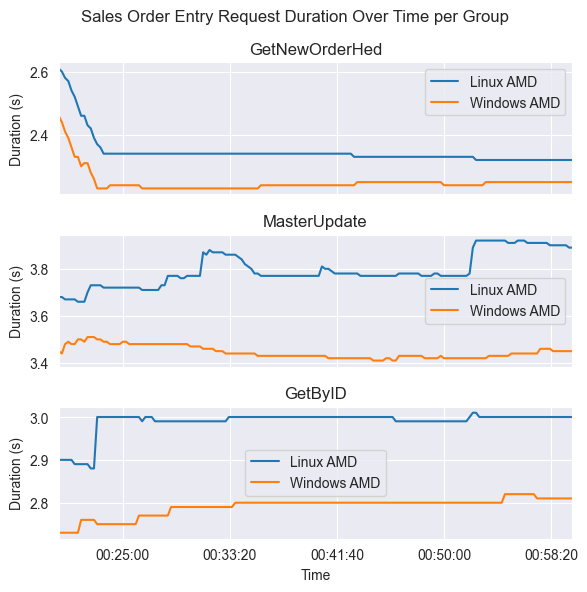

In [13]:
plot_grouped_queries_over_time(sales_order_entry_durations, ['GetNewOrderHed', 'MasterUpdate', 'GetByID'], "Sales Order Entry Request Duration Over Time per Group", "Duration Over Time", "Duration (s)", grouper="method")
save_plot_if_new("results/sales_order_entry_groups_duration_over_time.png")

In [14]:
def get_percentage_diff(df: pd.DataFrame, group_col: str, value_col: str, reference_instance: str) -> tuple[pd.Series, pd.Series]:
    means = df.groupby(group_col)[value_col].mean()
    reference_value = means[reference_instance]
    difference = means - reference_value
    percentage_diff = (difference / reference_value) * 100
    return difference, percentage_diff

def get_percentage_interpretation(dest: tuple[pd.Series, pd.Series], interpreter = lambda x: f'{x:.2f}% faster' if x < 0 else f'{x:.2f}% slower' if x > 0 else 'same', col_name="diff (s)"):
    interpretation = dest[1].apply(interpreter)
    return pd.DataFrame({'% diff': interpretation, col_name: dest[0]})

durations_dest = sales_order_entry_durations.groupby("instance")["value"].describe()
durations_dest

,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
Linux AMD,483.0,3.043375,0.595357,2.32,2.34,3.0,3.77,3.92
Windows AMD,483.0,2.828406,0.490604,2.23,2.25,2.8,3.42,3.51


In [15]:
get_percentage_interpretation(get_percentage_diff(durations_dest, "instance", "mean", "Windows AMD"))

,% diff,diff (s)
instance,,
Linux AMD,7.60% slower,0.214969
Windows AMD,same,0.000000


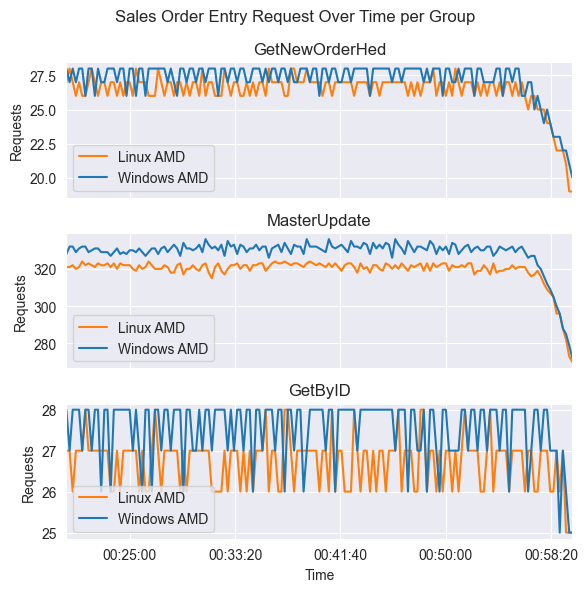

In [16]:
plot_grouped_queries_over_time(sales_order_entry_requests, ['GetNewOrderHed', 'MasterUpdate', 'GetByID'], "Sales Order Entry Request Over Time per Group", "Request Over Time", "Requests", grouper="method")
save_plot_if_new("results/sales_order_entry_groups_requests_over_time.png")

In [17]:
requests_dest = sales_order_entry_requests.groupby("instance")["value"].describe()
requests_dest

,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
Linux AMD,483.0,124.178054,138.249809,19.0,27.0,27.0,319.0,324.0
Windows AMD,483.0,127.784679,142.270209,20.0,27.0,28.0,329.0,336.0


In [18]:
get_percentage_interpretation(get_percentage_diff(requests_dest, "instance", "mean", "Windows AMD"), lambda x: f'{x:.2f}% more requests' if x < 0 else f'{x:.2f}% less requests' if x > 0 else 'Same Requests', col_name="diff (requests)")

,% diff,diff (requests)
instance,,
Linux AMD,-2.82% more requests,-3.606625
Windows AMD,Same Requests,0.000000


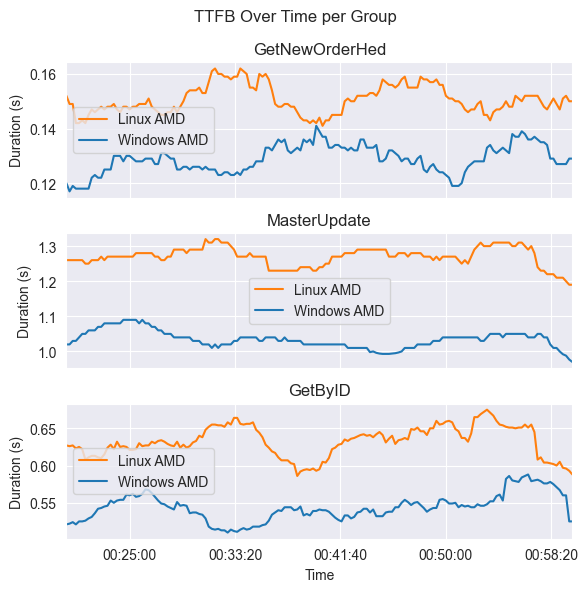

In [19]:
plot_grouped_queries_over_time(sales_order_entry_ttfb, ['GetNewOrderHed', 'MasterUpdate', 'GetByID'], "TTFB Over Time per Group", "Duration Over Time", "Duration (s)", grouper="method")
save_plot_if_new("results/sales_order_entry_groups_ttfb.png")

In [20]:
ttfb_dest = sales_order_entry_ttfb.groupby("instance")["value"].describe()
ttfb_dest

,count,mean,std,min,25%,50%,75%,max
instance,,,,,,,,
Linux AMD,483.0,0.684460,0.459360,0.141,0.1545,0.633,1.26,1.32
Windows AMD,483.0,0.568839,0.370795,0.117,0.1330,0.543,1.02,1.09


In [21]:
get_percentage_interpretation(get_percentage_diff(ttfb_dest, "instance", "mean", "Windows AMD"))

,% diff,diff (s)
instance,,
Linux AMD,20.33% slower,0.115621
Windows AMD,same,0.000000
